In [2]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd

In [3]:
%matplotlib inline

In [4]:
import h5py
from scipy.io import savemat

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from matplotlib import colors

### Load Data

In [6]:
snapshots = 100
nx = 256
ny = 128
nz = 160

In [7]:
filename = "/Users/Alex/Desktop/MEng_Resources/2D_3D_DNS_Data/snapshots.pkl"

In [8]:
with open(filename, 'rb') as f:
    obj = pickle.load(f)
    uvw3D_field = obj

In [9]:
uvw3D_field.shape

(100, 256, 128, 160, 3)

### Load Trained Model

In [57]:
model = tf.keras.models.load_model("/Users/Alex/Desktop/MEng_Resources/Project_Run_Logbook/100_xscan_dt5_Run/Test_Model")


In [77]:
# Linear interpolation test
interp_file = "/Users/Alex/Desktop/MEng_Resources/Project_Run_Logbook/linear_int_xscan_dt5"

with open(interp_file, 'rb') as f:
    obj = pickle.load(f)
    predicted_field = obj

### Prepare Prediction Input

In [58]:
# Define empty 2D dataset of 5 sections to predict 3D field
snapshot = 49
dt = 5 # in snapshots
test_sections = np.empty([ny, nz, 15])

slice_pos = np.array([(nx - 1) * 0.1, (nx - 1) * 0.3, (nx - 1) * 0.5, (nx - 1) * 0.7, (nx - 1) * 0.9])
slice_pos = slice_pos.astype(int)

In [59]:
test_sections[:, :, 0:3] = uvw3D_field[snapshot - 2*dt, slice_pos[0], :, :, :]
test_sections[:, :, 3:6] = uvw3D_field[snapshot - dt, slice_pos[1], :, :, :]
test_sections[:, :, 6:9] = uvw3D_field[snapshot, slice_pos[2], :, :, :]
test_sections[:, :, 9:12] = uvw3D_field[snapshot + dt, slice_pos[3], :, :, :]
test_sections[:, :, 12:] = uvw3D_field[snapshot + 2*dt, slice_pos[4], :, :, :]

In [60]:
test_sections.shape

(128, 160, 15)

In [61]:
test_sections = np.expand_dims(test_sections, axis=0)

In [62]:
test_sections.shape

(1, 128, 160, 15)

### Make Prediction

In [63]:
predicted_field = model.predict(test_sections, batch_size=1)

In [64]:
predicted_field.shape

(1, 128, 160, 256, 3)

In [65]:
predicted_field = np.squeeze(predicted_field, axis=0)

In [66]:
predicted_field = np.transpose(predicted_field, (2,0,1,3))

In [67]:
predicted_field.shape

(256, 128, 160, 3)

### Accuracy of Prediction

In [68]:
true_field = uvw3D_field[snapshot,:,:,:,:]

In [69]:
true_field_zero_mean = np.zeros(true_field.shape)
#Subtract mean from each component
true_field_zero_mean[:,:,:,0] = true_field[:,:,:,0] - np.mean(true_field[:,:,:,0])
true_field_zero_mean[:,:,:,1] = true_field[:,:,:,1] - np.mean(true_field[:,:,:,1])
true_field_zero_mean[:,:,:,2] = true_field[:,:,:,2] - np.mean(true_field[:,:,:,2])

In [70]:
pred_flat = np.ravel(predicted_field)
true_flat = np.ravel(true_field)
true_flat_zero_mean = np.ravel(true_field_zero_mean)
error = true_flat - pred_flat

In [71]:
L2 = np.linalg.norm(error) / np.linalg.norm(true_flat_zero_mean)

In [72]:
L2

0.41137566447310664

### Calculate Velocity Components & Vorticity

In [91]:
u_pred = predicted_field[:,:,:,0]
v_pred = predicted_field[:,:,:,1]
w_pred = predicted_field[:,:,:,2]

u_true = uvw3D_field[snapshot,:,:,:,0]
v_true = uvw3D_field[snapshot,:,:,:,1]
w_true = uvw3D_field[snapshot,:,:,:,2]

In [92]:
z_plane = 83

In [93]:
u_pred = predicted_field[:,:,:,0]
v_pred = predicted_field[:,:,:,1]
w_pred = predicted_field[:,:,:,2]

u_true = uvw3D_field[snapshot,:,:,:,0]
v_true = uvw3D_field[snapshot,:,:,:,1]
w_true = uvw3D_field[snapshot,:,:,:,2]

In [94]:
x_plane = 159

In [95]:
u_true_plot = np.ma.array(u_true)

v_true_plot = np.ma.array(v_true)

w_true_plot = np.ma.array(w_true)

u_pred_plot = np.ma.array(u_pred)

v_pred_plot = np.ma.array(v_pred)

w_pred_plot = np.ma.array(w_pred)

In [96]:
u_colour = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0.75, vmax=2)
v_colour = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=1.5)
w_colour = colors.TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.3)
w_cheat = colors.TwoSlopeNorm(vmin=-0.05, vcenter=0, vmax=0.05)

In [97]:
x = np.linspace(0,16,256)
y = np.linspace(-2,2,128)
z = np.linspace(-2,2,160)

Y,Z = np.meshgrid(y,z,indexing='ij')

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,u_true_plot[x_plane,:,:],levels=500, alpha=0.98, cmap='bwr', norm=u_colour)
cb = plt.colorbar(ticks = [0.4,1.3])
cb.ax.tick_params(labelsize=22)

In [ ]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,v_true_plot[x_plane,:,:],levels=500, alpha=0.95, cmap='bwr', norm=v_colour)
cb = plt.colorbar(ticks = [-0.3,0.0,0.6])
cb.ax.tick_params(labelsize=22)

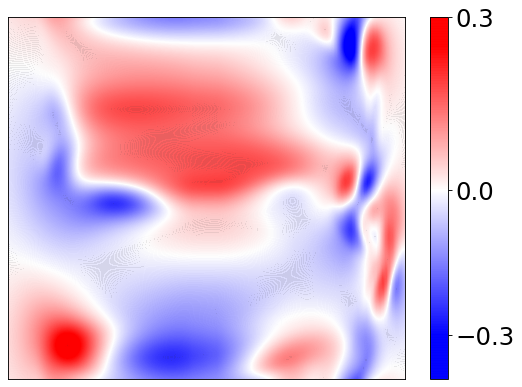

In [67]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,w_true_plot[x_plane,:,:],levels=500, alpha=0.9, cmap='bwr', norm = w_colour)
cb = plt.colorbar(ticks = [-0.3, 0.0, 0.3])
cb.ax.tick_params(labelsize=22)

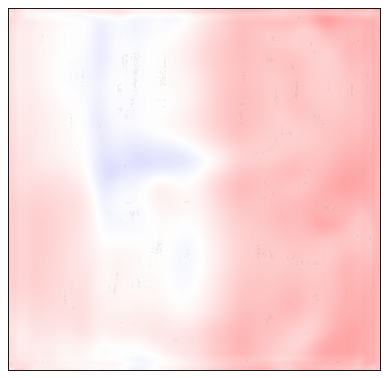

In [68]:
fig = plt.figure(figsize=(6, 6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,u_pred_plot[x_plane,:,:],levels=1000, alpha=0.95, cmap='bwr', norm=u_colour)
cb.ax.tick_params(labelsize=22)

In [69]:
L2_u = np.linalg.norm(u_pred_plot[x_plane,:,:]- u_true_plot[x_plane,:,:]) / np.linalg.norm(u_true_plot[x_plane,:,:])
L2_u

0.12218856670430316

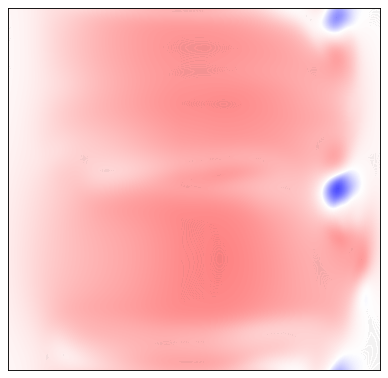

In [70]:
fig = plt.figure(figsize=(6,6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,v_true_plot[x_plane,:,:],levels=1000, alpha=0.95, cmap='bwr', norm=v_colour)
cb.ax.tick_params(labelsize=22)

In [71]:
L2_v = np.linalg.norm(v_pred_plot[x_plane,:,:]- v_true_plot[x_plane,:,:]) / np.linalg.norm(v_true_plot[x_plane,:,:])
L2_v

0.33638149895253694

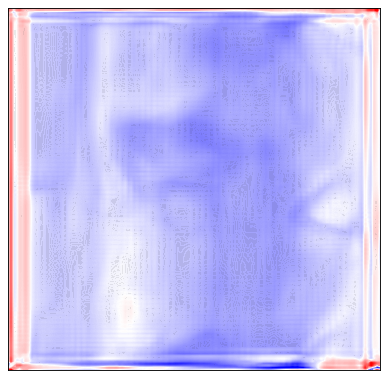

In [72]:
fig = plt.figure(figsize=(6,6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,w_pred_plot[x_plane,:,:],levels=500, alpha=0.9, cmap='bwr', norm = w_cheat)
cb.ax.tick_params(labelsize=22)

In [73]:
np.max(w_pred_plot[159])

0.05965609

In [74]:
L2_v = np.linalg.norm(w_pred_plot[x_plane,:,:]- w_true_plot[x_plane,:,:]) / np.linalg.norm(w_true_plot[x_plane,:,:])
L2_v

1.029850450761432

In [83]:
def vorticity(u,v,w):
    
    dudx = np.empty(u.shape)
    dudy = np.empty(u.shape)
    dudz = np.empty(u.shape)

    dvdx = np.empty(v.shape)
    dvdy = np.empty(v.shape)
    dvdz = np.empty(v.shape)

    dwdx = np.empty(w.shape)
    dwdy = np.empty(w.shape)
    dwdz = np.empty(w.shape)
    
    dudx, dudy, dudz = np.gradient(u)
    dvdx, dvdy, dvdz = np.gradient(v)
    dwdx, dwdy, dwdz = np.gradient(w)
    
    omegax = dwdy-dvdz
    omegay = dudz-dwdx
    omegaz = dvdx-dudy
    
    return omegax, omegay, omegaz

In [84]:
omegax_pred, omegay_pred, omegaz_pred = vorticity(u_pred, v_pred, w_pred)

In [85]:
omegax_true, omegay_true, omegaz_true = vorticity(u_true, v_true, w_true)

In [86]:
omega_pred = np.power(omegax_pred[x_plane,:,:]**2 + omegay_pred[x_plane,:,:]**2 + omegaz_pred[x_plane,:,:]**2,0.5)
omega_true = np.power(omegax_true[x_plane,:,:]**2 + omegay_true[x_plane,:,:]**2 + omegaz_true[x_plane,:,:]**2,0.5)

In [87]:
omega_pred_plot = np.ma.array(omega_pred)
omega_true_plot = np.ma.array(omega_true)

In [97]:
normalise_error = colors.Normalize(0.0,0.3)
normalise_vort_cheat = colors.Normalize(0.0,0.2)

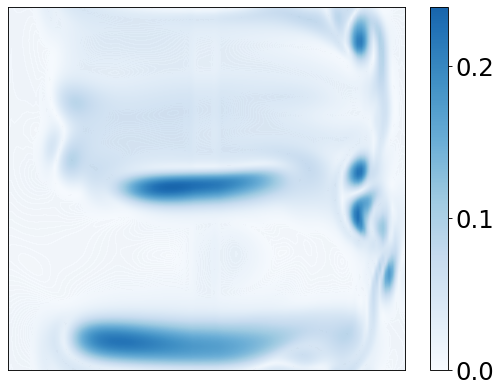

In [92]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,omega_true_plot,levels=500, alpha=0.98, cmap='Blues', norm=normalise_error)
cb = plt.colorbar(ticks = [0.0, 0.1, 0.2, 0.6, 0.8])
cb.ax.tick_params(labelsize=22)

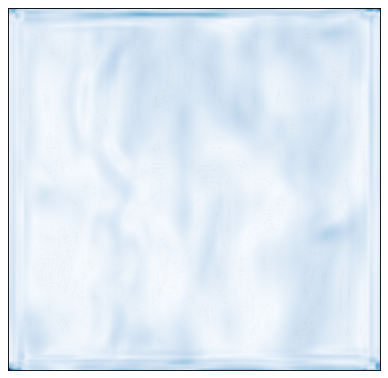

In [103]:
fig = plt.figure(figsize=(6,6), dpi=80)
plt.gca().patch.set_color('.2')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.contourf(Y,Z,omega_pred_plot,levels=500, alpha=0.98, cmap='Blues', norm=normalise_vort_cheat)
cb.ax.tick_params(labelsize=16)

In [100]:
vorticity_error = abs(omega_true_plot - omega_pred_plot)

In [101]:
L2_vort = np.linalg.norm(omega_pred_plot- omega_true_plot) / np.linalg.norm(omega_true_plot)
L2_vort

0.8175700980711695

### Variation of Error with x/D

In [32]:
predicted_field.shape

(256, 128, 160, 3)

In [33]:
np.ravel(predicted_field[x_plane,:,:]).shape[0] == 128 *160 * 3

True

In [77]:
L2_x = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    error_x = flat_true - flat_pred
    L2_x[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true)

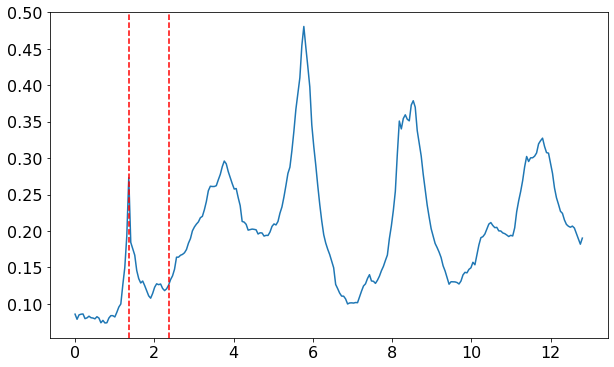

In [78]:
x = np.linspace(0, 12.8, nx)

plt.figure(figsize=(10, 6))
plt.plot(x, L2_x, label='dataset size')
plt.axvline(x=1.37, ymin=0, ymax=1, color='r', linestyle='--')
plt.axvline(x=2.37, ymin=0, ymax=1, color='r', linestyle='--')
plt.tick_params(labelsize=16)

### Comparing L2 vs x/D across different dt training

In [118]:
L2_0 = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_0[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [136]:
L2_2 = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_2[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [97]:
L2_5 = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_5[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [148]:
np.mean(L2_5)

0.4163662539173466

Text(0, 0.5, '$\\epsilon$')

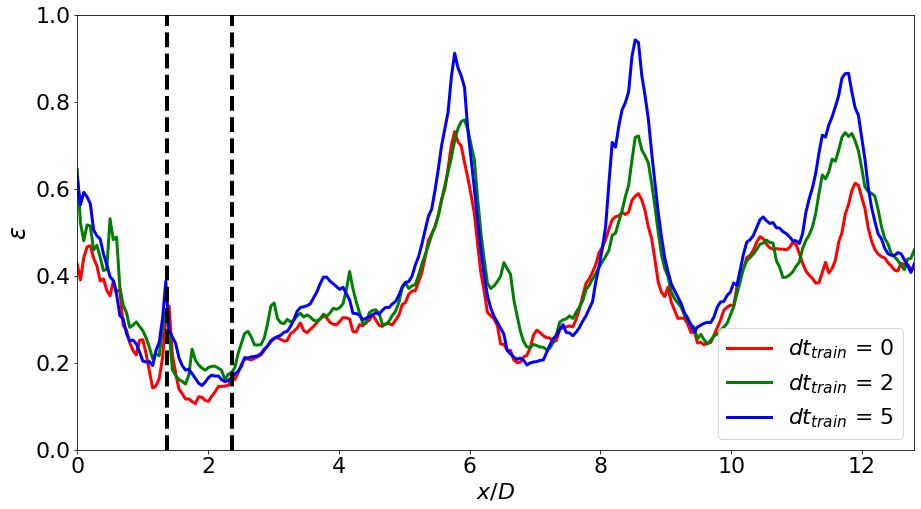

In [162]:
x = np.linspace(0, 12.8, nx)

plt.figure(figsize=(15, 8))
plt.plot(x, L2_0, 'r-', linewidth=3, label='$dt_{train}$ = 0')
plt.plot(x, L2_2, 'g', linewidth=3, label='$dt_{train}$ = 2')
plt.plot(x, L2_5, 'b-', linewidth=3, label='$dt_{train}$ = 5')
plt.axvline(x=1.37, ymin=0, ymax=1, color='k', linewidth=4, linestyle='--')
plt.axvline(x=2.37, ymin=0, ymax=1, color='k', linewidth=4, linestyle='--')
plt.tick_params(labelsize=22)
plt.xlim(0,12.8)
plt.ylim(0,1)
plt.legend(loc='lower right', prop={'size': 22})
plt.xlabel('$x/D$', size=22)
plt.ylabel('$\epsilon$', size=24)

### Dt Sweep

In [141]:
time_delta = np.arange(21)
dt_errors_1 = []
dt_errors_2 = []
dt_errors_3 = []

In [151]:
for dt in time_delta:
    # Define empty 2D dataset of 5 sections to predict 3D field
    test_sections = np.empty([ny, nz, 15])
    snapshot = 49

    slice_pos = np.array([(nx - 1) * 0.1, (nx - 1) * 0.3, (nx - 1) * 0.5, (nx - 1) * 0.7, (nx - 1) * 0.9])
    slice_pos = slice_pos.astype(int)
    
    test_sections[:, :, 0:3] = uvw3D_field[snapshot - 2*dt, slice_pos[0], :, :, :]
    test_sections[:, :, 3:6] = uvw3D_field[snapshot - dt, slice_pos[1], :, :, :]
    test_sections[:, :, 6:9] = uvw3D_field[snapshot, slice_pos[2], :, :, :]
    test_sections[:, :, 9:12] = uvw3D_field[snapshot + dt, slice_pos[3], :, :, :]
    test_sections[:, :, 12:] = uvw3D_field[snapshot + 2*dt, slice_pos[4], :, :, :]
    
    test_sections = np.expand_dims(test_sections, axis=0)
    
    predicted_field = model.predict(test_sections, batch_size=1)
    predicted_field = np.squeeze(predicted_field, axis=0)
    predicted_field = np.transpose(predicted_field, (2,0,1,3))
    
    true_field = uvw3D_field[snapshot,:,:,:,:]
    
    true_field_zero_mean = np.zeros(true_field.shape)
    #Subtract mean from each component
    true_field_zero_mean[:,:,:,0] = true_field[:,:,:,0] - np.mean(true_field[:,:,:,0])
    true_field_zero_mean[:,:,:,1] = true_field[:,:,:,1] - np.mean(true_field[:,:,:,1])
    true_field_zero_mean[:,:,:,2] = true_field[:,:,:,2] - np.mean(true_field[:,:,:,2])
    
    pred_flat = np.ravel(predicted_field)
    true_flat = np.ravel(true_field)
    flat_true_zero_mean = np.ravel(true_field_zero_mean)
    error = true_flat - pred_flat
    
    dt_errors_3.append(np.linalg.norm(error) / np.linalg.norm(flat_true_zero_mean))

In [158]:
len(dt_errors_2)

22

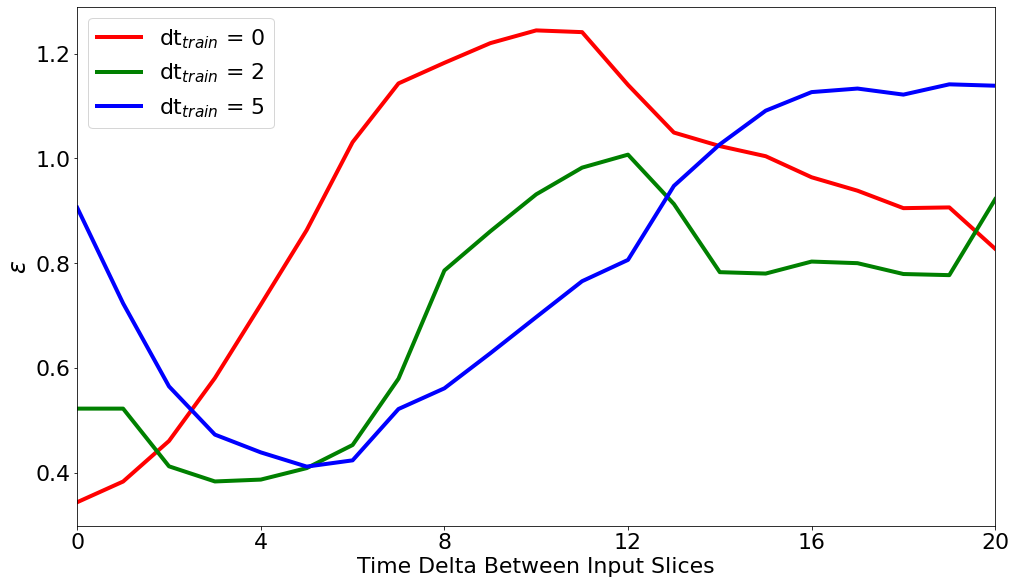

In [161]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(14, 8)
ax.plot(time_delta, dt_errors_1, 'r', linewidth=4, label='dt$_{train}$ = 0')
ax.plot(time_delta, dt_errors_2[:-1], 'g', linewidth=4, label='dt$_{train}$ = 2')
ax.plot(time_delta, dt_errors_3, 'b', linewidth=4, label='dt$_{train}$ = 5')
ax.set_xlabel("Time Delta Between Input Slices", fontsize=22)
ax.set_ylabel("$\epsilon$", fontsize=24)
#ax.set_title("Reconstruction for Different Time Delta Between Snapshots", fontsize=18)
ax.tick_params(labelsize=22)
ax.set_xticks([0,4,8,12,16,20])
plt.xlim(0,20)
plt.legend(loc='best', prop={'size': 22})


# def forward(x):
#     return 2 * x / 26


# def inverse(x):
#     return 26 * x / 2

# secax = ax.secondary_xaxis('top', functions=(forward, inverse))
# secax.set_xlabel('Fractions of Characteristic Timescale', fontsize=22)
# secax.tick_params(labelsize=22)
# plt.show()

### Comparison to Linear Interpolation

In [29]:
L2_dt0_lin = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_dt0_lin[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [26]:
L2_dt0 = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_dt0[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [31]:
e_dt0 = L2_dt0_lin - L2_dt0

In [75]:
L2_dt2_lin = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_dt2_lin[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [53]:
L2_dt2 = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_dt2[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [76]:
e_dt2 = L2_dt2_lin - L2_dt2

In [78]:
L2_dt5_lin = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_dt5_lin[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [73]:
L2_dt5 = np.zeros(nx)

for i in range(nx):
    flat_pred = np.ravel(predicted_field[i,:,:])
    flat_true = np.ravel(true_field[i,:,:])
    flat_true_zero_mean = np.ravel(true_field_zero_mean[i,:,:])
    error_x = flat_true - flat_pred
    L2_dt5[i] = np.linalg.norm(error_x) / np.linalg.norm(flat_true_zero_mean)

In [79]:
e_dt5 = L2_dt5_lin - L2_dt5

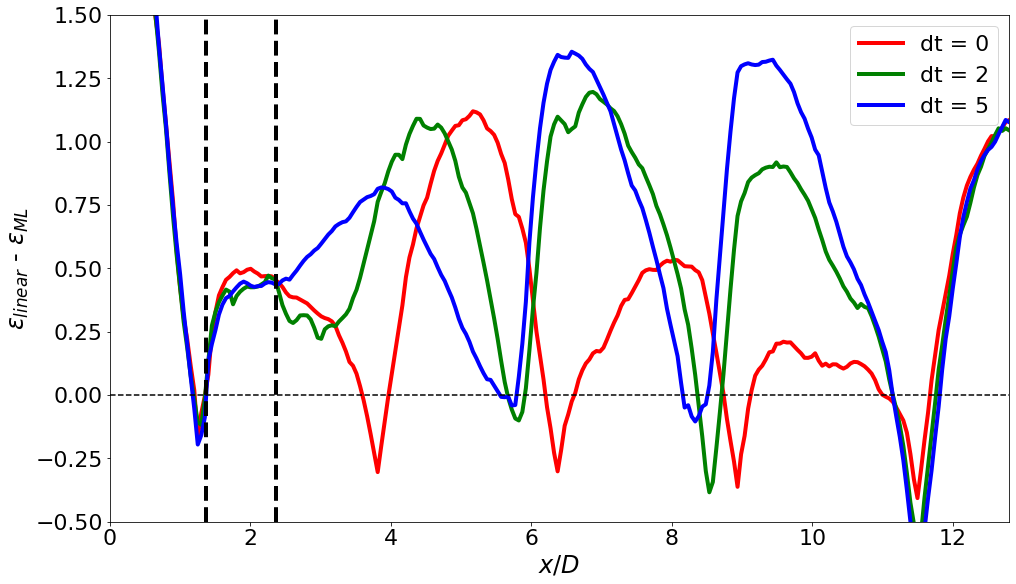

In [84]:
x = np.linspace(0, 12.8, nx)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(14, 8)
ax.plot(x, e_dt0, 'r', linewidth=4, label='dt = 0')
ax.plot(x, e_dt2, 'g', linewidth=4, label='dt = 2')
ax.plot(x, e_dt5, 'b', linewidth=4, label='dt = 5')
ax.plot(x, np.zeros(x.shape), 'k--')
ax.set_xlabel("$x/D$", fontsize=24)
ax.set_ylabel("$\epsilon_{linear}$ - $\epsilon_{ML}$", fontsize=24)
plt.axvline(x=1.37, ymin=0, ymax=1, color='k', linewidth=4, linestyle='--')
plt.axvline(x=2.37, ymin=0, ymax=1, color='k', linewidth=4, linestyle='--')
#ax.set_title("Reconstruction for Different Time Delta Between Snapshots", fontsize=18)
ax.tick_params(labelsize=22)
plt.xlim(0,12.8)
plt.ylim(-0.5,1.5)
plt.legend(loc='best', prop={'size': 22})